In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.datasets as datasets
import torchvision.utils as vutils

import os
import json
import numpy as np
import csv
import pandas as pd
import math
import numpy as np
import glob
import tqdm
import sys
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg
from tqdm import tqdm

import seaborn as sns
sns.set_theme(style="ticks")

import torchvision
from torchvision.io import read_image

sys.path.insert(0, '/home/sharifullina/thesis/Soft-DTW-Loss/')
from sdtw_cuda_loss import SoftDTW

In [2]:
%load_ext tensorboard
from torch.utils.tensorboard import SummaryWriter

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [4]:
# target_folder = './extracted/mwd/nopims/'
target_folder = '/home/sharifullina/thesis/datasets/extracted/mwd/volve/'
# target_folder = '/Users/ramilasarifullina/Desktop/extracted/well_logs/volve/'
# target_folder = '/Users/ramilasarifullina/Desktop/extracted/well_logs/nopims/'

# dataset

In [5]:
wells = os.listdir(target_folder)
len(wells)

23

In [6]:
required_params_plus = ['DEPTH', 'ROPA', 'HKLA', 'WOB', 'SPPA', 'WELL']
required_params = ['DEPTH', 'ROPA', 'HKLA', 'WOB', 'SPPA']

In [7]:
logs = [json.load(open(os.path.join(target_folder, wells[i]), 'r')) for i in range(len(wells))]

In [8]:
dataset_all = [pd.DataFrame(logs[i]['data'], columns=[x['name'] for x in logs[i]['curves']]) for i in range(len(logs))]
for i in range(len(dataset_all)):
    dataset_all[i]['WELL'] = wells[i]

dataset = []
for df in dataset_all:
    dataset.append(df[required_params_plus])
    
X_all = dataset[0]
for i in range(1, len(dataset)):
    X_all = pd.concat([X_all, dataset[i]], ignore_index = True)
X_all = X_all.ffill().bfill()

In [9]:
X_list = []
for i in range(0, len(X_all) - 64, 10):
    X_list.append(X_all[i : 64 + i])

In [10]:
X_list_minus = []
for x in X_list:
    X_list_minus.append(x.loc[:, x.columns != 'WELL'])

In [11]:
X = []
for i in X_list_minus:
    X.append(i.values)

In [12]:
X = np.dstack(X)
X = np.rollaxis(X, -1)
X.shape

(5920, 64, 5)

In [13]:
map_well_to_label = {w:i for i, w in enumerate(wells)}

In [14]:
y = np.array([map_well_to_label[df['WELL'].iloc[0]] for df in X_list])
y.shape

(5920,)

In [15]:
class DataSet():
    def __init__(self, data, labels, feature_scales={}, N=25000, length_lim=90, sparse_rate=1):

#         if len(data) > N:
#             sub_inds = np.random.choice(len(data), N, replace=False)
#         else:
#             sub_inds = np.arange(len(data))
        
        self.data = data
        self.data = torch.tensor(self.data).to(torch.float32)
        self.labels = torch.tensor(labels)
        self.sparse_rate = sparse_rate
        self.feature_scales = feature_scales
        
        for f in range(data.shape[2]):
            self.data[:, :, f] = (self.data[:, :, f].T - self.data[:, :, f].mean(axis=1)).T 
            
        for f in range(data.shape[2]):
            if f not in feature_scales:
                std = self.data[:, :, f].ravel().std()
                feature_scales[f] = std
            self.data[:, :, f] = self.data[:, :, f]/feature_scales[f]
            
        self.data = self.data.transpose(1, 2)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i], self.labels[i]

In [16]:
torch_dataset = DataSet(X, y, sparse_rate=1)


In [17]:
train_n = 4000
train_set, val_set = torch.utils.data.random_split(torch_dataset, [train_n, len(torch_dataset) - train_n])

In [18]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=True)

In [19]:
for x_t, y_t in train_loader:
    print(x_t.shape)
    print(y_t.shape)
    break

torch.Size([64, 5, 64])
torch.Size([64])


---

# Model

In [21]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, 2, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose1d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x


class Generator(nn.Module):
    def __init__(self, in_channels=len(required_params), features=32):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv1d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(
            features * 2, features * 4, down=True, act="leaky", use_dropout=False
        )
        self.down3 = Block(
            features * 4, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down4 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down5 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down6 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.bottleneck = nn.Sequential(
            nn.Conv1d(features * 8, features * 8, 4, 2, 1), nn.ReLU()
        )

        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up3 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up4 = Block(
            features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False
        )
        self.up5 = Block(
            features * 8, features * 2, down=False, act="relu", use_dropout=False
        )
        self.up6 = Block(
            features * 4 , features, down=False, act="relu", use_dropout=False
        )
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose1d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),
            # nn.Tanh(),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        return d6
    
        

    def forward(self, x):
#         print('x', x.shape)
        d1 = self.initial_down(x)
#         print('d1', d1.shape)
        d2 = self.down1(d1)
#         print('d2', d2.shape)
        d3 = self.down2(d2)
#         print('d3', d3.shape)
        d4 = self.down3(d3)
#         print('d4', d4.shape)
        d5 = self.down4(d4)
#         print('d5', d5.shape)
        d6 = self.down5(d5)
#         print('d6', d6.shape)
        bottleneck = self.bottleneck(d6)
#         print('bottleneck', bottleneck.shape)
        up1 = self.up1(bottleneck)
#         print('up1', up1.shape)
        if up1.shape != d6.shape:
            up1 = TF.resize(up1, size=d6.shape[1:]) 
        up2 = self.up2(torch.cat([up1, d6], 1))
#         print('up2', up2.shape)
        if up2.shape != d5.shape:
            up2 = TF.resize(up2, size=d5.shape[1:])
        up3 = self.up3(torch.cat([up2, d5], 1))
#         print('up3', up3.shape)
        if up3.shape != d4.shape:
            up3 = TF.resize(up3, size=d4.shape[1:])
        up4 = self.up4(torch.cat([up3, d4], 1))
#         print('up4', up4.shape)
        if up4.shape != d3.shape:
            up4 = TF.resize(up4, size=d3.shape[1:])
        up5 = self.up5(torch.cat([up4, d3], 1))
#         print('up5', up5.shape)
        if up5.shape != d2.shape:
            up5 = TF.resize(up5, size=d2.shape[1:])
        up6 = self.up6(torch.cat([up5, d2], 1))
#         print('up6', up6.shape)
        if up6.shape != d1.shape:
            up6 = TF.resize(up6, size=d1.shape[1:])
        return self.final_up(torch.cat([up6, d1], 1))
        

In [22]:
# check
model_gen = Generator()
for i, data in enumerate(train_loader):
    x, y = data
    print(x.shape)
    print(y.shape)
    out = model_gen(x)
    break

out.shape

torch.Size([64, 5, 64])
torch.Size([64])


torch.Size([64, 5, 64])

In [23]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(CNNBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(
                in_channels, out_channels, 4, stride, 1, bias=False, padding_mode="reflect"
            ),
            nn.BatchNorm1d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=len(required_params), features=[32, 64, 128, 256]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv1d(
                in_channels ,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2),
            )
            in_channels = feature

        layers.append(
            nn.Conv1d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"
            ),
        )
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        x = self.model(x)
        return x


In [24]:
# check
model_disk = Discriminator()
for i, data in enumerate(train_loader):
    x, y = data
    out = model_disk(x)
    break

out.shape

torch.Size([64, 1, 6])

## inception time

In [25]:
from inceptiontime.src.models.inception import InceptionModel

In [26]:
model_inception = InceptionModel(num_blocks=2, in_channels=len(required_params), 
                       out_channels=30,
                       bottleneck_channels=12, kernel_sizes=15,
                       use_residuals=True, 
                       num_pred_classes=len(wells)).cuda()

In [27]:
optimizer = torch.optim.Adam(model_inception.parameters(), lr=1e-3)
best_val_loss = np.inf
patience_counter = 0
best_state_dict = None
criterion = nn.CrossEntropyLoss()

In [28]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []
num_epochs = 100

In [29]:
for epoch in range(num_epochs):
    model_inception.train();
    epoch_train_loss = []
    all_preds = []
    all_y = []
    for x_t, y_t in train_loader:
        x_t = x_t.cuda()
        y_t = y_t.cuda()
        optimizer.zero_grad()
        output = model_inception(x_t)
        loss = criterion(output, y_t)
        epoch_train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        _, preds = torch.max(output, 1)
        all_preds.append(preds)
        all_y.append(y_t)
    train_loss.append(np.mean(epoch_train_loss))
    train_acc.append(float((torch.cat(all_preds) == torch.cat(all_y)).float().mean().cpu().data.numpy()))
    epoch_val_loss = []
    model_inception.eval()
    all_preds = []
    all_y = []
    for x_v, y_v in val_loader:
        x_v = x_v.cuda()
        y_v = y_v.cuda()
        with torch.no_grad():
            output = model_inception(x_v)
            loss = criterion(output, y_v)
            epoch_val_loss.append(loss.item())
            _, preds = torch.max(output, 1)
            all_preds.append(preds)
            all_y.append(y_v)
    val_loss.append(np.mean(epoch_val_loss))
    val_acc.append(float((torch.cat(all_preds) == torch.cat(all_y)).float().mean().cpu().data.numpy()))

    print(f'Epoch: {epoch + 1}, '
          f'Train loss: {round(train_loss[-1], 3)}, '
          f'Val loss: {round(val_loss[-1], 3)}, '
          f'Train acc: {round(train_acc[-1], 3)}, '
          f'Val acc: {round(val_acc[-1], 3)}, ')

Epoch: 1, Train loss: 3.035, Val loss: 2.993, Train acc: 0.084, Val acc: 0.105, 
Epoch: 2, Train loss: 2.921, Val loss: 2.87, Train acc: 0.107, Val acc: 0.12, 
Epoch: 3, Train loss: 2.84, Val loss: 2.846, Train acc: 0.118, Val acc: 0.12, 
Epoch: 4, Train loss: 2.808, Val loss: 2.801, Train acc: 0.127, Val acc: 0.11, 
Epoch: 5, Train loss: 2.796, Val loss: 2.788, Train acc: 0.12, Val acc: 0.121, 
Epoch: 6, Train loss: 2.771, Val loss: 2.765, Train acc: 0.127, Val acc: 0.117, 
Epoch: 7, Train loss: 2.755, Val loss: 2.761, Train acc: 0.133, Val acc: 0.126, 
Epoch: 8, Train loss: 2.741, Val loss: 2.794, Train acc: 0.144, Val acc: 0.123, 
Epoch: 9, Train loss: 2.722, Val loss: 2.738, Train acc: 0.148, Val acc: 0.153, 
Epoch: 10, Train loss: 2.709, Val loss: 2.748, Train acc: 0.164, Val acc: 0.151, 
Epoch: 11, Train loss: 2.706, Val loss: 2.727, Train acc: 0.159, Val acc: 0.163, 
Epoch: 12, Train loss: 2.685, Val loss: 2.732, Train acc: 0.171, Val acc: 0.149, 
Epoch: 13, Train loss: 2.677, V

## training model

In [30]:
lr = 3e-4
batch_size = 128
num_epochs = 100
n_noise = 256
n_critic = 1

In [31]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

criterion_gan = nn.BCELoss()
criterion_soft_dtw = SoftDTW(use_cuda=True, gamma=0.1)
D_opt = torch.optim.Adam(discriminator.parameters(), lr = lr)
G_opt = torch.optim.Adam(generator.parameters(), lr = lr)
# Soft_dtw_opt = torch.optim.Adam(generator.parameters(), lr = lr)
fixed_noise = torch.randn((batch_size, len(required_params), 64)).to(device)

In [32]:
print('Discriminator paramteres:', sum(p.numel() for p in discriminator.parameters() if p.requires_grad))
print('Generator paramteres:', sum(p.numel() for p in generator.parameters() if p.requires_grad))

Discriminator paramteres: 174625
Generator paramteres: 2419237


In [33]:
writer_fake = SummaryWriter(f"/home/sharifullina/thesis/logs_cGAN_time_series/fake")
writer_real = SummaryWriter(f"/home/sharifullina/thesis/logs_cGAN_time_series/real")

In [34]:
G_losses = []
D_losses = []
img_list = []

In [35]:
generator.train()
discriminator.train()

G_loss_list = []
D_loss_list = []

for epoch in range(num_epochs):
    for idx, data_all in enumerate(train_loader):
    
        step = 0
        data, y = data_all
        data = data.to(device)
        y = y.to(device)
        real_data = data.to(device)
        batch_size = real_data.size(0)
        noise = torch.randn(real_data.size(0), len(required_params), 64, device=device)

        D_opt.zero_grad()
        G_opt.zero_grad()

        fake = generator(noise)
#         Ssim_loss = criterion_ssim(real_data, noise)
        # classificator
        output_class = model_inception(data)
        loss_class = criterion(output_class, y)

        disc_real = discriminator(real_data)        
        D_loss_1 = criterion_gan(disc_real, torch.ones_like(disc_real))        
        disc_fake = discriminator(fake)
        D_loss_2 = criterion_gan(disc_fake, torch.zeros_like(disc_fake))
        D_loss = (D_loss_1 + D_loss_2) / 2 + loss_class * 0.001
#         + abs(Ssim_loss)
        D_opt.zero_grad()
        D_loss.backward(retain_graph=True)
        D_opt.step()

        output = discriminator(fake)
        G_loss = criterion_gan(output, torch.ones_like(output))
        G_opt.zero_grad()
        G_loss.backward()
        G_opt.step()

        G_loss_list.append(G_loss.item())
        D_loss_list.append(D_loss.item())

        if idx % 10 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {idx}/{len(train_loader)} \
            Loss D: {D_loss:.4f}, loss G: {G_loss:.4f}")

            step += 1
            


Epoch [0/100] Batch 0/63             Loss D: 0.7087, loss G: 0.8210
Epoch [0/100] Batch 10/63             Loss D: 0.6970, loss G: 0.9057
Epoch [0/100] Batch 20/63             Loss D: 0.6012, loss G: 1.1300
Epoch [0/100] Batch 30/63             Loss D: 0.6021, loss G: 1.2970
Epoch [0/100] Batch 40/63             Loss D: 0.5811, loss G: 1.4607
Epoch [0/100] Batch 50/63             Loss D: 0.4808, loss G: 1.5532
Epoch [0/100] Batch 60/63             Loss D: 0.5311, loss G: 2.0244
Epoch [1/100] Batch 0/63             Loss D: 0.3858, loss G: 2.0714
Epoch [1/100] Batch 10/63             Loss D: 0.3379, loss G: 2.1392
Epoch [1/100] Batch 20/63             Loss D: 0.2464, loss G: 1.8610
Epoch [1/100] Batch 30/63             Loss D: 0.2460, loss G: 2.0095
Epoch [1/100] Batch 40/63             Loss D: 0.3023, loss G: 1.8875
Epoch [1/100] Batch 50/63             Loss D: 0.5199, loss G: 1.5594
Epoch [1/100] Batch 60/63             Loss D: 0.5229, loss G: 1.8127
Epoch [2/100] Batch 0/63            

Epoch [17/100] Batch 10/63             Loss D: 0.0226, loss G: 4.4328
Epoch [17/100] Batch 20/63             Loss D: 0.0152, loss G: 4.7282
Epoch [17/100] Batch 30/63             Loss D: 0.0144, loss G: 4.8506
Epoch [17/100] Batch 40/63             Loss D: 0.0257, loss G: 4.9922
Epoch [17/100] Batch 50/63             Loss D: 0.0333, loss G: 4.5051
Epoch [17/100] Batch 60/63             Loss D: 0.0276, loss G: 4.5137
Epoch [18/100] Batch 0/63             Loss D: 0.0196, loss G: 4.6255
Epoch [18/100] Batch 10/63             Loss D: 0.0493, loss G: 4.4018
Epoch [18/100] Batch 20/63             Loss D: 0.0209, loss G: 4.8589
Epoch [18/100] Batch 30/63             Loss D: 0.0131, loss G: 4.8772
Epoch [18/100] Batch 40/63             Loss D: 0.0178, loss G: 4.8081
Epoch [18/100] Batch 50/63             Loss D: 0.0414, loss G: 4.9904
Epoch [18/100] Batch 60/63             Loss D: 0.0128, loss G: 5.4537
Epoch [19/100] Batch 0/63             Loss D: 0.0125, loss G: 5.6813
Epoch [19/100] Batch 1

Epoch [34/100] Batch 10/63             Loss D: 0.0092, loss G: 4.9149
Epoch [34/100] Batch 20/63             Loss D: 0.0058, loss G: 5.8282
Epoch [34/100] Batch 30/63             Loss D: 0.0071, loss G: 5.3305
Epoch [34/100] Batch 40/63             Loss D: 0.0057, loss G: 5.5495
Epoch [34/100] Batch 50/63             Loss D: 0.0156, loss G: 5.3345
Epoch [34/100] Batch 60/63             Loss D: 0.0050, loss G: 5.9687
Epoch [35/100] Batch 0/63             Loss D: 0.0046, loss G: 5.8107
Epoch [35/100] Batch 10/63             Loss D: 0.0071, loss G: 5.6735
Epoch [35/100] Batch 20/63             Loss D: 0.0051, loss G: 5.7086
Epoch [35/100] Batch 30/63             Loss D: 0.0046, loss G: 6.0632
Epoch [35/100] Batch 40/63             Loss D: 0.0052, loss G: 5.8623
Epoch [35/100] Batch 50/63             Loss D: 0.0051, loss G: 5.9848
Epoch [35/100] Batch 60/63             Loss D: 0.0053, loss G: 6.3103
Epoch [36/100] Batch 0/63             Loss D: 0.0039, loss G: 6.4741
Epoch [36/100] Batch 1

Epoch [51/100] Batch 10/63             Loss D: 0.0031, loss G: 7.3963
Epoch [51/100] Batch 20/63             Loss D: 0.0057, loss G: 6.5365
Epoch [51/100] Batch 30/63             Loss D: 0.0041, loss G: 6.8767
Epoch [51/100] Batch 40/63             Loss D: 0.0039, loss G: 7.4569
Epoch [51/100] Batch 50/63             Loss D: 0.0039, loss G: 6.5641
Epoch [51/100] Batch 60/63             Loss D: 0.0032, loss G: 7.6378
Epoch [52/100] Batch 0/63             Loss D: 0.0032, loss G: 7.1631
Epoch [52/100] Batch 10/63             Loss D: 0.0040, loss G: 6.7269
Epoch [52/100] Batch 20/63             Loss D: 0.0050, loss G: 6.6530
Epoch [52/100] Batch 30/63             Loss D: 0.0037, loss G: 6.6889
Epoch [52/100] Batch 40/63             Loss D: 0.0103, loss G: 6.8200
Epoch [52/100] Batch 50/63             Loss D: 0.0037, loss G: 6.9693
Epoch [52/100] Batch 60/63             Loss D: 0.0032, loss G: 6.9836
Epoch [53/100] Batch 0/63             Loss D: 0.0031, loss G: 7.2928
Epoch [53/100] Batch 1

Epoch [68/100] Batch 10/63             Loss D: 0.0028, loss G: 7.5025
Epoch [68/100] Batch 20/63             Loss D: 0.0032, loss G: 7.4868
Epoch [68/100] Batch 30/63             Loss D: 0.0027, loss G: 7.8628
Epoch [68/100] Batch 40/63             Loss D: 0.0027, loss G: 8.2699
Epoch [68/100] Batch 50/63             Loss D: 0.0026, loss G: 7.6126
Epoch [68/100] Batch 60/63             Loss D: 0.0024, loss G: 8.4780
Epoch [69/100] Batch 0/63             Loss D: 0.0026, loss G: 7.7973
Epoch [69/100] Batch 10/63             Loss D: 0.0028, loss G: 8.0577
Epoch [69/100] Batch 20/63             Loss D: 0.0030, loss G: 8.0086
Epoch [69/100] Batch 30/63             Loss D: 0.0033, loss G: 7.1297
Epoch [69/100] Batch 40/63             Loss D: 0.0029, loss G: 8.1004
Epoch [69/100] Batch 50/63             Loss D: 0.0026, loss G: 7.8059
Epoch [69/100] Batch 60/63             Loss D: 0.0035, loss G: 8.3556
Epoch [70/100] Batch 0/63             Loss D: 0.0026, loss G: 7.7838
Epoch [70/100] Batch 1

Epoch [85/100] Batch 10/63             Loss D: 0.0049, loss G: 7.6048
Epoch [85/100] Batch 20/63             Loss D: 0.0029, loss G: 9.2709
Epoch [85/100] Batch 30/63             Loss D: 0.0031, loss G: 8.2215
Epoch [85/100] Batch 40/63             Loss D: 0.0033, loss G: 8.2893
Epoch [85/100] Batch 50/63             Loss D: 0.0035, loss G: 8.2790
Epoch [85/100] Batch 60/63             Loss D: 0.0027, loss G: 8.4079
Epoch [86/100] Batch 0/63             Loss D: 0.0029, loss G: 8.1943
Epoch [86/100] Batch 10/63             Loss D: 0.0028, loss G: 7.9415
Epoch [86/100] Batch 20/63             Loss D: 0.0039, loss G: 8.1567
Epoch [86/100] Batch 30/63             Loss D: 0.0029, loss G: 8.4068
Epoch [86/100] Batch 40/63             Loss D: 0.0041, loss G: 8.7428
Epoch [86/100] Batch 50/63             Loss D: 0.0029, loss G: 8.7982
Epoch [86/100] Batch 60/63             Loss D: 0.0034, loss G: 8.9137
Epoch [87/100] Batch 0/63             Loss D: 0.0029, loss G: 8.3654
Epoch [87/100] Batch 1

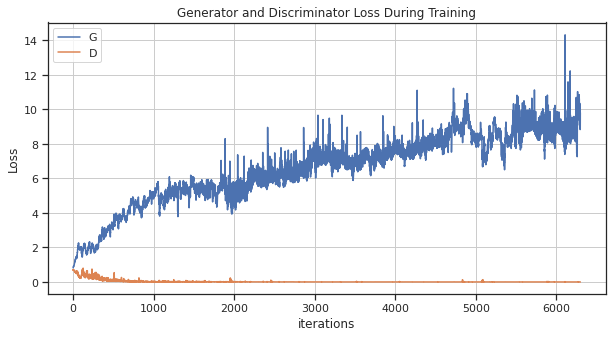

In [41]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_loss_list,label="G")
plt.plot(D_loss_list,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig('/home/sharifullina/thesis/losses/loss_cGAN_time_series_inception_class.png')
plt.show()

## test

In [42]:
scales_vectors = np.array([torch_dataset.feature_scales[f] for f in range(len(required_params))])

sparse_rate = torch_dataset.sparse_rate
print('sparse_rate', sparse_rate)
L = 64
print('L', L)
# window = L * sparse_rate
window = 64
print('window', window)
step = 4
print('step', step)

sparse_rate 1
L 64
window 64
step 4


In [43]:
test_well = wells[22]
test_well

'well_17.json'

In [44]:
X_test = pd.DataFrame(logs[22]['data'], columns=[x['name'] for x in logs[22]['curves']])
X_test = X_test[required_params]
X_test = X_test.drop_duplicates()

In [45]:
y_name = 'DEPTH'

In [46]:
X_test

,DEPTH,ROPA,HKLA,WOB,SPPA
0,223.0,1.50,96.39,0.19,84.75
1,224.0,3.84,97.11,0.60,77.10
2,225.0,3.51,96.76,0.58,85.56
3,226.0,21.85,97.11,0.36,53.67
4,227.0,33.79,94.76,2.55,53.96
...,...,...,...,...,...
3405,3628.0,15.04,156.24,5.77,218.70
3406,3629.0,15.04,155.61,6.36,218.79
3407,3630.0,15.04,155.27,6.58,218.60
3408,3631.0,15.04,155.71,6.26,218.71


In [47]:
def apply_window_transform(x, s, latent_noise_rate=0):
    x = x[np.arange(0, len(x), sparse_rate), :]
    mean_x = x.mean(axis=0)
    x = (x - mean_x)/s
    with torch.no_grad():
        x = torch.Tensor(x).view(1, x.shape[0], -1).to(device)
        z = generator(x.transpose(1, 2))
    
    return z.transpose(1, 2)[0].cpu().data.numpy()*s + mean_x, z.transpose(1, 2)[0].cpu().data.numpy()

In [48]:
def apply_rolling_transform(X, w, scales, step=12):
    Z = []
    
    for i in tqdm(range(0, len(X) - w, step)):
        Z.append(apply_window_transform(X[i: i+w], scales))
        
    return Z

In [ ]:
Z = apply_rolling_transform(X_test[required_params].values, window, scales_vectors, step)

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 807/837 [00:04<00:00, 205.49it/s]

In [ ]:
original = []
generated = []

t = X_test[y_name].astype(float).values
plt.figure(figsize=(14, 10))
for i, curve_name in enumerate(required_params):
    plt.subplot(1, len(df.columns) - 1, i + 1)
#     for zi, x in tqdm(enumerate(range(0, len(df_well) - window, step))):
#         plt.plot(Z[zi][0][:, i], t[np.arange(x, x+window, sparse_rate)], color='C1', alpha=0.5, lw=0.5)

    zis = range(0, len(X_test) - window, step)
    A = np.zeros((len(zis), len(X_test))) * np.nan
    for zi, x in tqdm(enumerate(zis)):
        A[zi, np.arange(x, x+window, sparse_rate)] = Z[zi][0][:, i]
    
    A = np.nanmean(A, axis=0)
    not_nan_inds = np.where(~np.isnan(A))[0]
    
    original.append(X_test[curve_name].astype(float).values)
    generated.append(A[not_nan_inds])
    
    plt.plot(A[not_nan_inds], t[not_nan_inds], color='C1', lw=1)
    plt.plot(X_test[curve_name].astype(float).values, t, lw=1, color='C0', alpha=0.5)
    plt.grid()
    axis = plt.gca()
    axis.invert_yaxis()
    axis.xaxis.tick_top()
    axis.xaxis.set_label_position('top')
    if i > 0: axis.set_yticklabels([])

    if i == 0:
        plt.ylabel(f'{y_name}')
    plt.xlabel(f'{curve_name}')

plt.tight_layout()


In [ ]:
df1 = pd.DataFrame(original).T
df1.columns = required_params
df1 = df1.assign(WELL=lambda x: 'original')

df2 = pd.DataFrame(generated).T
df2.columns = required_params
df2 = df2.assign(WELL=lambda x: 'generated')

df_some = pd.concat([df1, df2], ignore_index = True)
df_some

In [ ]:
for i in required_params[:-1]:
    sns.displot(data=df_some, 
            x=i, hue='WELL', kind='kde',
            fill=True, palette=sns.color_palette('bright')[:2], height=5, aspect=1.5
               )